In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_scaled = scaler.transform(y_test_reshaped)

<h1>Ensemble Model</h1>

In [15]:
import tensorflow as tf
from tensorflow import keras
import subprocess
import sys
try:
    from scikeras.wrappers import KerasRegressor
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikeras"])
    from scikeras.wrappers import KerasRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import xgboost
import catboost as cb
tf.random.set_seed(42)
np.random.seed(42)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [16]:
import joblib

mlp = joblib.load('best_mlp.joblib')
catboost = joblib.load('catboost_model.joblib')
xgb = joblib.load('xgb_model 24Aug25.joblib')

In [17]:
# Make predictions on the training data
mlp_train_pred = mlp.predict(X_train_processed)
catboost_train_pred = catboost.predict(X_train_processed)
xgb_train_pred = xgb.predict(X_train_processed)

# Make predictions on the test data
mlp_test_pred = mlp.predict(X_test_processed)
catboost_test_pred = catboost.predict(X_test_processed)
xgb_test_pred = xgb.predict(X_test_processed)

# Stack the training predictions horizontally to create the new feature set
stacked_train_features = np.column_stack((
    mlp_train_pred,
    catboost_train_pred,
    xgb_train_pred
))

# Do the same for the test predictions
stacked_test_features = np.column_stack((
    mlp_test_pred,
    catboost_test_pred,
    xgb_test_pred
))

4249/4249 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and train the meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_train_features, y_train_scaled)

# Make final predictions with the meta-model
ensemble_pred_scaled = meta_model.predict(stacked_test_features)

# Inverse transform to get the predictions in the original scale
ensemble_pred = scaler.inverse_transform(ensemble_pred_scaled.reshape(-1, 1))

# Calculate the RMSE of the ensemble model
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print(f"Ensemble Model RMSE: {rmse_ensemble:.4f}")

Ensemble Model RMSE: 27720.6486


In [21]:
import joblib
joblib.dump(meta_model,'ensemble_model.joblib')

['ensemble_model.joblib']

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Model Performance Report (RMSE) ---

----- RMSE by town -----
           town         RMSE
    BUKIT TIMAH 52299.192876
         BISHAN 51016.735923
   CENTRAL AREA 50343.088124
     QUEENSTOWN 43084.552505
  MARINE PARADE 42925.977965
    BUKIT MERAH 41271.044231
      TOA PAYOH 38118.932262
KALLANG/WHAMPOA 36599.039323
       CLEMENTI 33958.110896
          BEDOK 33617.797853
        HOUGANG 32953.739774
       TAMPINES 32919.212037
      SERANGOON 32802.475998
        GEYLANG 32607.255840
     ANG MO KIO 31932.003616
      PASIR RIS 28371.961297
    JURONG EAST 27613.171512
  BUKIT PANJANG 26373.553869
    BUKIT BATOK 26180.343165
    JURONG WEST 24500.024539
      WOODLANDS 24037.867003
       SENGKANG 23409.370485
  CHOA CHU KANG 22950.889611
        PUNGGOL 22322.513991
         YISHUN 20524.789933
      SEMBAWANG 18858.478793


----- RMSE by flat_type -----
       flat_type         RMSE
MULTI-GENERATION 48237.534347
       EXECUTIVE 4

C:\Users\Troyk\AppData\Local\Temp\ipykernel_5012\1263446479.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


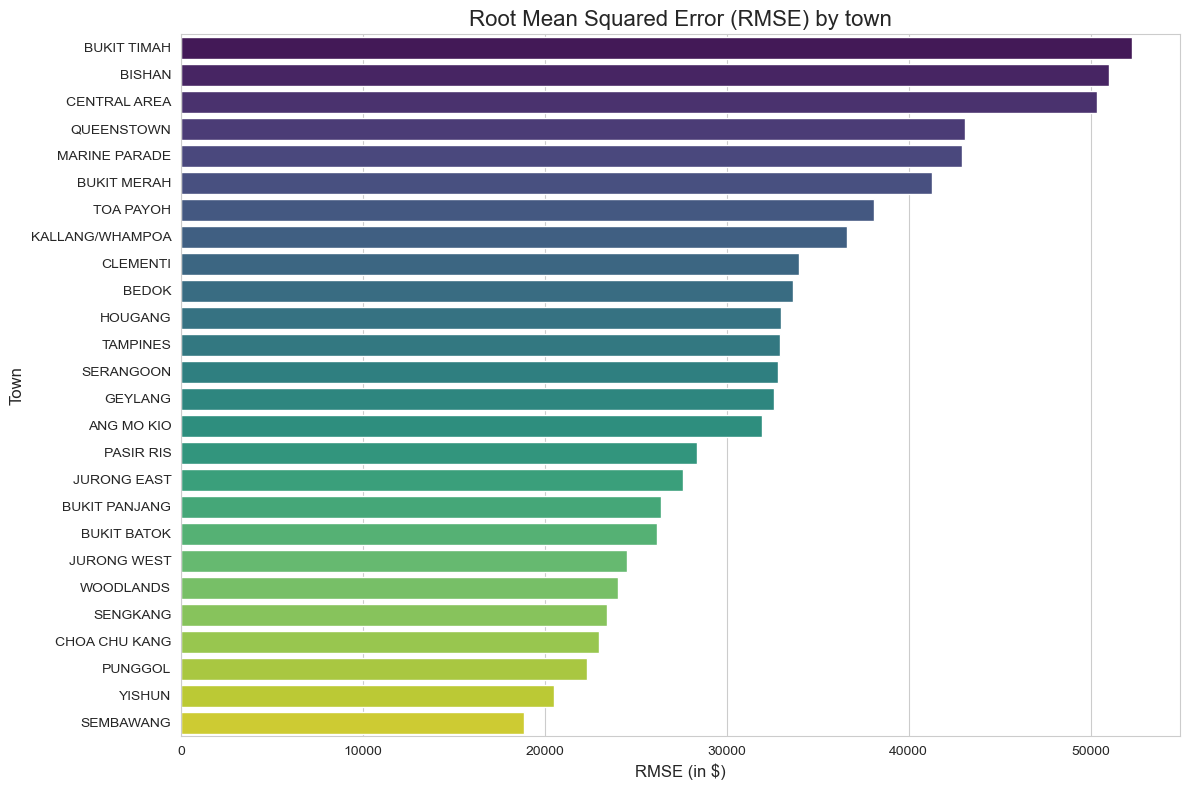

C:\Users\Troyk\AppData\Local\Temp\ipykernel_5012\1263446479.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')


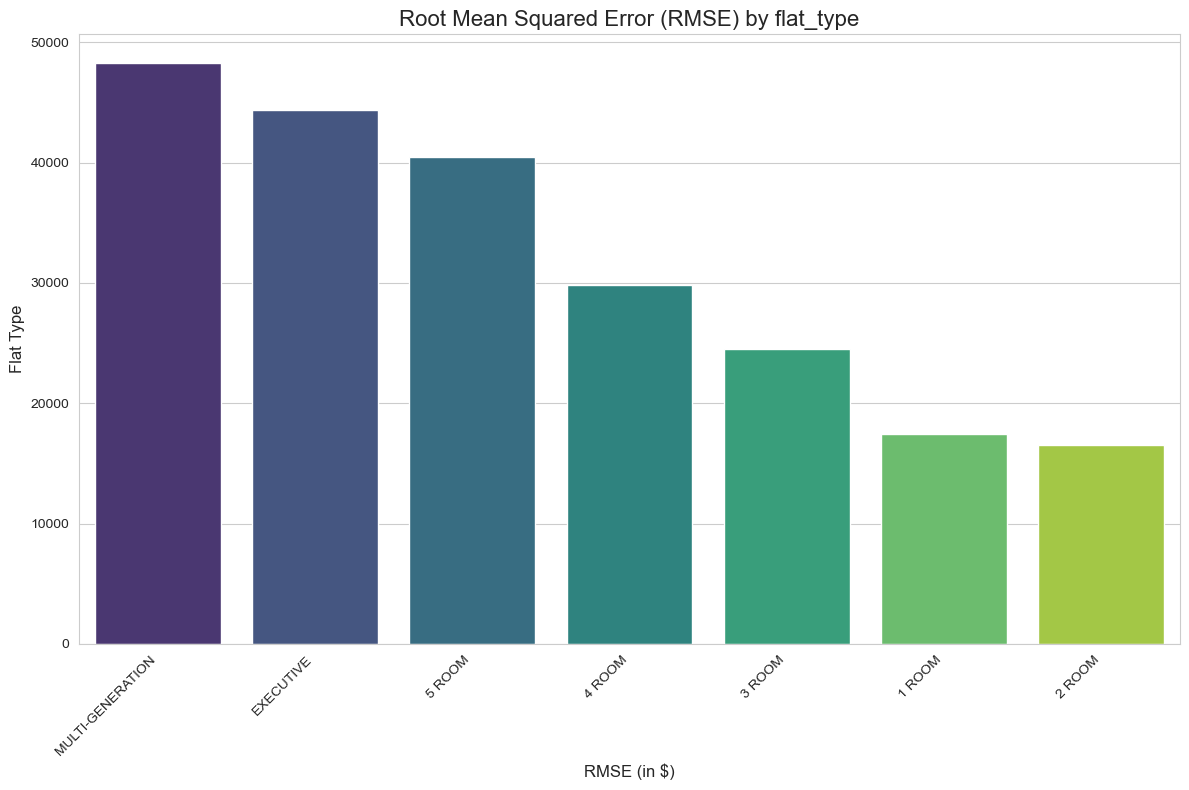

C:\Users\Troyk\AppData\Local\Temp\ipykernel_5012\1263446479.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')


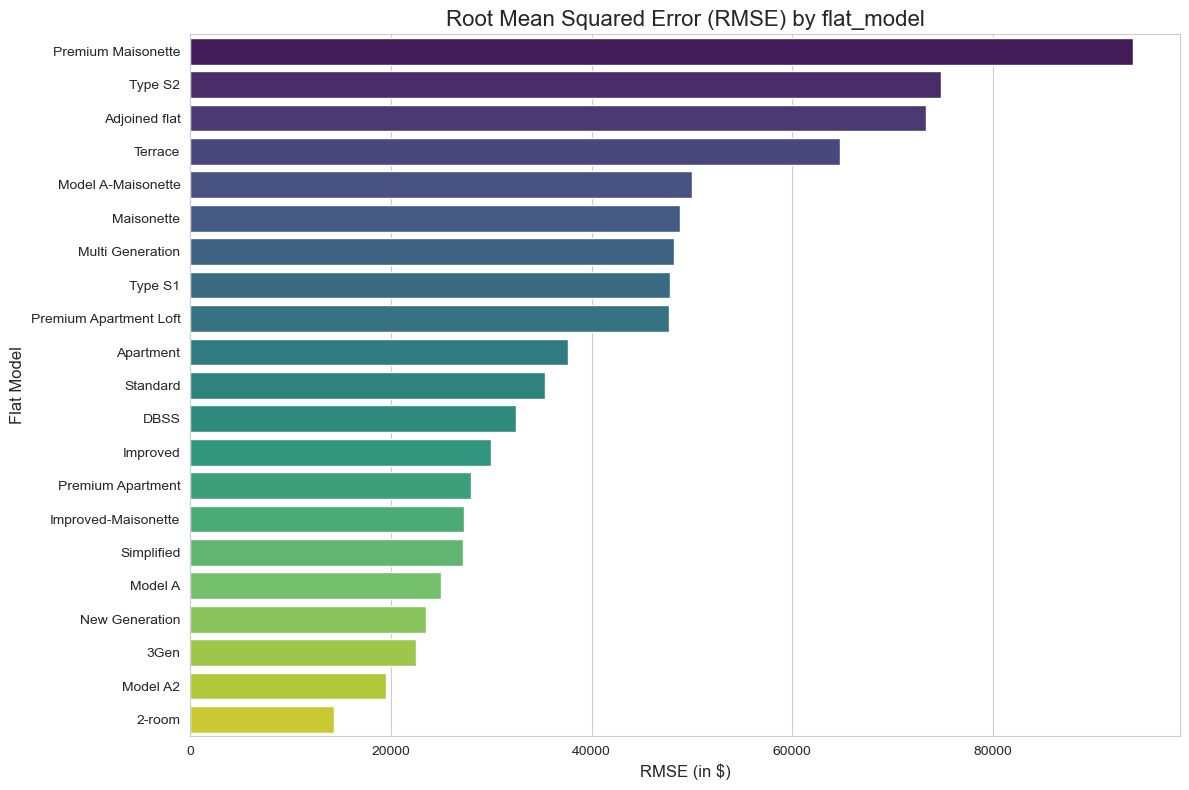

In [20]:
# You need to pass the base models to the function
def generate_model_report(
    meta_model,
    base_models,
    preprocessor,
    y_scaler,
    X_report,
    y_report
):
    # 1. Preprocess the report data
    X_report_processed = preprocessor.transform(X_report)

    # 2. Get predictions from each base model
    base_model_predictions = []
    for model in base_models:
        # Reshape for Keras/LSTM if needed
        if 'keras' in str(type(model)) and len(model.input_shape) == 3:
            X_report_reshaped = np.reshape(X_report_processed, (X_report_processed.shape[0], 1, X_report_processed.shape[1]))
            preds = model.predict(X_report_reshaped)
        else:
            preds = model.predict(X_report_processed)
        base_model_predictions.append(preds)

    # 3. Stack the base predictions to create the meta-features
    stacked_report_features = np.column_stack(base_model_predictions)

    # 4. Make final predictions with the meta-model
    y_pred_scaled = meta_model.predict(stacked_report_features)

    # 5. Inverse transform predictions to get actual prices
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
    y_true = y_report.values

    # (The rest of your function remains the same)
    # ...
    results_df = X_report.copy()
    results_df['true_price'] = y_true
    results_df['predicted_price'] = y_pred
    results_df['squared_error'] = (results_df['true_price'] - results_df['predicted_price'])**2
    report_cols = ['town', 'flat_type', 'flat_model']
    reports = {}
    print("--- Model Performance Report (RMSE) ---\n")
    for col in report_cols:
        rmse_by_class = results_df.groupby(col)['squared_error'].apply(lambda x: np.sqrt(x.mean()))
        report_df = rmse_by_class.reset_index(name='RMSE').sort_values('RMSE', ascending=False)
        reports[col] = report_df
        print(f"----- RMSE by {col} -----")
        print(report_df.to_string(index=False))
        print("\n" + "="*40 + "\n")
    sns.set_style("whitegrid")
    for col in report_cols:
        plt.figure(figsize=(12, 8))
        data_to_plot = reports[col].sort_values('RMSE', ascending=False)
        if len(data_to_plot) > 15:
            sns.barplot(x='RMSE', y=col, data=data_to_plot, palette='viridis')
        else:
            sns.barplot(x=col, y='RMSE', data=data_to_plot, palette='viridis')
            plt.xticks(rotation=45, ha='right')
        plt.title(f'Root Mean Squared Error (RMSE) by {col}', fontsize=16)
        plt.xlabel('RMSE (in $)', fontsize=12)
        plt.ylabel(col.replace('_', ' ').title(), fontsize=12)
        plt.tight_layout()
        plt.show()

# --- Call the function to generate the full report ---

# Create a list of your loaded base models
base_models = [mlp, catboost, xgb]

generate_model_report(
    meta_model=meta_model,
    base_models=base_models,  # Pass the list of base models here
    preprocessor=preprocessor,
    y_scaler=scaler,
    X_report=X_classification_report,
    y_report=y_classification_report
)